# Simulations to mimic experiments of [Flower mutant cocultures]((https://doi.org/10.1038/s41586-019-1429-3)):

The following is based on simulation of [spatial 2-variable Lotka-Volterra model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359763/#FD4), with the following equations:

$\left\{\begin{array}{c}\frac{\partial c_1(t,\boldsymbol x)}{\partial t}=\boldsymbol\nabla\cdot\lbrack D_1(c_1,c_2)\boldsymbol\nabla c_1(t,\boldsymbol x)\rbrack+g_1c_1(1-c_1-c_2)+\varepsilon_1c_1c_2,\\\frac{\partial c_2(t,\boldsymbol x)}{\partial t}=\boldsymbol\nabla\cdot\lbrack D_2(c_1,c_2)\boldsymbol\nabla c_2(t,\boldsymbol x)\rbrack+g_2c_2(1-c_1-c_2)+\varepsilon_2c_2c_1.\end{array}\right.$

where,

$\begin{array}{c}D_1(c_1,c_2)=D_{01}{(1-c_1-c_2)}^{\alpha_1}\text{  for }c_1+c_2<1,\\D_1(c_1,c_2)=0\text{  for }c_1+c_2>1,\end{array}$

In [70]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from flowermodel.simulations import Colony

SimulationParams = {'h':10.0/200.0,               # Interval size in xy-direction
                    'Radius':2.0,         # Radius of initial innoculation
                    'L':10.0,             # width/height of the simulation box}
                    'init_block_ratio':0.05, # Ratio of initialization block width to radius of initial innoculation
                    'NeumanStabilityConstant': 20.0, # Constant in the denominator of Von Neumann stability equation (https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis)
                    'MaxTime':5.0, # Maximum time for simulation
                    'init_mixing_ratio' : 0.5, # initial mixing ratio (type 1 concentration)
                    'RandomSeed':0 # random seed 
                    }

ModelParams = {'g1':10.0, # red
               'g2':10.0, # green
               'epsilon1':0.1,
               'epsilon2':0.1,
               'alpha1':1,
               'alpha2':1,
               'D01':0.01,
               'D02':0.01
              }

ThisColony = Colony(ModelParams, SimulationParams, plotrgb=True)
ThisColony.LoopThroughTime(Animate=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


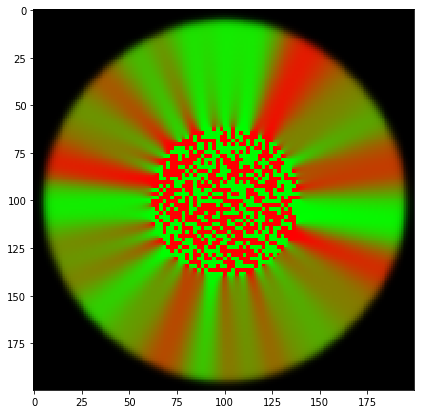

In [71]:
ThisColony.PlotConcentrations()

# Scratch

The following is my best reproduction of equations 3 and 4 from the following paper:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359763/#FD4.
Parameters are adopted from figure 6.

In [9]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt 
from time import time
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import time
np.seterr(all='raise')

class Colony:
    def __init__(self,ModelParams,SimulationParams):
        self.ModelParams = ModelParams
        self.SimulationParams = SimulationParams
        self.h = SimulationParams['h']                      # Interval size in xy-direction.    
        self.h2 = self.h**2
        self.dt = self.h2/self.SimulationParams['NeumanStabilityConstant']/np.max([self.ModelParams['D01'],self.ModelParams['D02']]);         # Time step
        self.nL=int(SimulationParams['L'] /self.h);     # Number of lattice points in each dimension
        self.w = int(SimulationParams['init_block_ratio']*SimulationParams['Radius'] /self.h) # width of initialization blocks
        
        np.random.seed(SimulationParams['RandomSeed'])
        
    def InitializeMatrices(self):                      
        # Initialize all matrices that will be called by reference                          
        self.c1 = np.zeros([self.nL,self.nL])                
        self.c2 = np.zeros([self.nL,self.nL])                

        # Now, set the initial conditions within a circle of radius 'Radius'. Set values of c1 to 0 and 1 randomly within blocks of side w. Set c2 = 1-c1
        for i in range(0,self.nL,self.w):
            for j in range(0,self.nL,self.w):
                if (i-self.nL/2.0)**2+(j-self.nL/2.0)**2 <= (self.SimulationParams['Radius']/self.h)**2:
                    c_eps = 0.001 # small deviation from 0 and 1 to avoid numerical instabilty
                    self.c1[i,j] = (np.random.rand()<0.5)*(1-2*c_eps)+c_eps
                    self.c1[i:i+self.w,j:j+self.w] = self.c1[i,j]
                    self.c2[i,j] = 1 - self.c1[i,j]
                    self.c2[i:i+self.w,j:j+self.w] = self.c2[i,j]

        for i in range(0,self.nL,1): # Prune the outside of circle by setting concentrations to 0
            for j in range(0,self.nL,1):
                if (i-self.nL/2.0)**2+(j-self.nL/2.0)**2 > (self.SimulationParams['Radius']/self.h)**2:
                    self.c1[i,j] = 0
                    self.c2[i,j] = 0
                    
        self.c1_pad=np.zeros([self.nL+2,self.nL+2])  # Padded c1
        self.c2_pad=np.zeros([self.nL+2,self.nL+2])  # Padded c2

        self.D_c1=np.zeros([self.nL,self.nL])       # Diffusion constant of c1
        self.D_c2=np.zeros([self.nL,self.nL])
        
        self.D_c1_pad=np.zeros([self.nL+2,self.nL+2])  # Padded diffusion constant of c1
        self.D_c2_pad=np.zeros([self.nL+2,self.nL+2])  # Padded diffusion constant of c2
        
    def PadMatrix(self,A,A_pad):         # Padding for no flux boundary conditions
        A_pad[1:-1,1:-1]=A
        A_pad[1:-1,0]=A[:,1]
        A_pad[1:-1,-1]=A[:,-2]
        A_pad[0,1:-1]=A[1,:]
        A_pad[-1,1:-1]=A[-2,:]
    
    def Laplacian(self,A,A_pad):
        return (A_pad[1:-1,0:-2] + A_pad[1:-1,2:] - 2*A)/self.h2+(A_pad[0:-2,1:-1] + A_pad[2:,1:-1] -2*A)/self.h2
    
    def Gradient_x(self,A_pad):
        return (A_pad[1:-1,2:] - A_pad[1:-1,0:-2])/(2*self.h);
    
    def Gradient_y(self,A_pad):
        return (A_pad[2:,1:-1] - A_pad[0:-2,1:-1])/(2*self.h);
    
    def DiffusionTerm(self,A,A_pad,D_A,D_A_pad):
#         import ipdb;ipdb.set_trace()
        self.PadMatrix(D_A,D_A_pad)
        self.PadMatrix(A,A_pad)
        self.temp_lap = self.Laplacian(A,A_pad)
        self.temp_gradx = self.Gradient_x(A_pad)
        self.temp_grady = self.Gradient_y(A_pad)
        self.temp_gradx_D=self.Gradient_x(D_A_pad)
        self.temp_grady_D=self.Gradient_y(D_A_pad)
        
        return D_A*self.temp_lap+ (self.temp_gradx_D*self.temp_gradx + self.temp_grady_D*self.temp_grady)
    
    def evolve_ts(self):
        '''
        This function evolves the equations of motion for one time step using Euler method
        '''
        # Equations of diffusion constant
        self.unused = 1-self.c1-self.c2
        self.D_c1 = (self.unused>0)*self.ModelParams['D01']*(self.unused)**self.ModelParams['alpha1']
        self.D_c2 = (self.unused>0)*self.ModelParams['D02']*(self.unused)**self.ModelParams['alpha2']
        
        # Equations of concentration dynamics
        self.c1=self.c1+self.dt*(self.DiffusionTerm(self.c1,self.c1_pad,self.D_c1,self.D_c1_pad)+
                                 self.ModelParams['g1']*self.c1*self.unused+
                                 self.ModelParams['epsilon1']*self.c2*self.c1)
        self.c2=self.c2+self.dt*(self.DiffusionTerm(self.c2,self.c2_pad,self.D_c2,self.D_c2_pad)+
                                 self.ModelParams['g2']*self.c2*self.unused+
                                 self.ModelParams['epsilon2']*self.c2*self.c1)

        
    def LoopThroughTime(self,Animate = False):  # Now, start the time evolution calculation...
        self.time_store = np.arange(0,self.SimulationParams['MaxTime'],self.dt)

        self.InitializeMatrices()
        for t in tqdm(self.time_store):                
            self.evolve_ts()
            if Animate:
                self.PlotConcentrations()
                display.clear_output(wait=True)
                display.display(plt.gcf())
                time.sleep(0.1)

    def PlotConcentrations(self):
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        plt.imshow(self.c1, cmap='afmhot');plt.colorbar();plt.title('c1',fontsize=16,fontweight='bold')
        plt.subplot(1,2,2)
        plt.imshow(self.c2, cmap='afmhot');plt.colorbar();plt.title('c2',fontsize=16,fontweight='bold')

SimulationParams = {'h':10.0/200.0,               # Interval size in xy-direction
                    'Radius':2.0,         # Radius of initial innoculation
                    'L':10.0,             # width/height of the simulation box}
                    'init_block_ratio':0.1, # Ratio of initialization block width to radius of initial innoculation
                    'NeumanStabilityConstant': 20.0, # Constant in the denominator of Von Neumann stability equation (https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis)
                    'MaxTime':3.0, # Maximum time for simulation
                    'RandomSeed':0 # random seed 
                    }

ModelParams = {'g1':12.5,
               'g2':10.0,
               'epsilon1':0,
               'epsilon2':0,
               'alpha1':1,
               'alpha2':1,
               'D01':0.01,
               'D02':0.01
              }

ThisColony = Colony(ModelParams, SimulationParams)
ThisColony.LoopThroughTime(Animate=False)

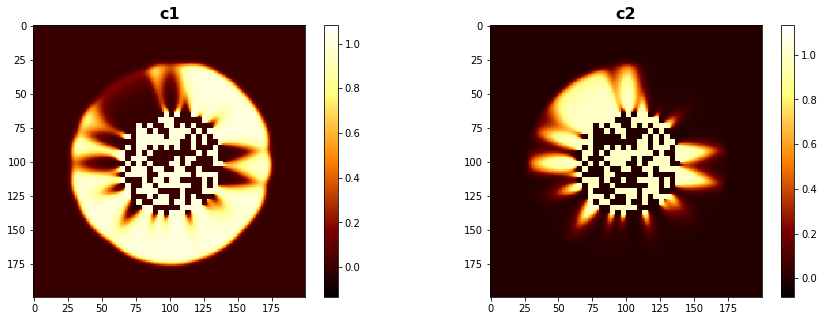

In [10]:
ThisColony.PlotConcentrations()